<h1>Tampa CS Pilot BSM Data<h1>

<h3>1. Plotting Data-points in My Maps<h3>

We plot Tampa BSM data in Google Maps.


![alt text](https://drive.google.com/uc?id=1atPFq_5ushumpWh9Vq3kwEFkNYcJYOmu)

<h3>2. Speed Inspection: Observing the trends in acceleration<h3

Based on the data-points for Jan 31, 2020 from 5PM to 7PM, the acceleration vs time show unrealistic variations beyond realistic ranges indicating possible inaccuracy in recorded latitude-longitude or time-stamp.

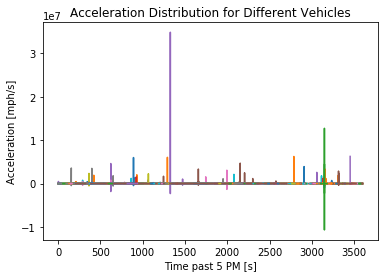

In [0]:
import matplotlib.pyplot as plt 

n=0; m=0
Data=[]
id=''
with open('RawBSMData_2020-01-31_17-18.csv') as file:
  for line in file:
    n+=1
    if n>1:
      m+=1
      f=line.split('\n')[0].split(',')
      if id!=f[1]:
        id=f[1]
        m=1
        Data.append([[], []])
      if m>2:
        try:
          a, b= float(f[0]), float(f[6])
          Data[-1][0].append(a)
          Data[-1][1].append(b)
        except ValueError:
          continue

k=0
for i in Data:
  k+=1
  plt.plot(i[0], i[1], label=str(k))
plt.xlabel('Time past 5 PM [s]')
plt.ylabel('Acceleration [mph/s]')
plt.title('Acceleration Distribution for Different Vehicles')
plt.show()


<h3>3. Smoothening out the data to reduce data inaccuracy: 3-point moving average<h3>

To encounter that issues, we do a three-point moving average on the time-stamp, latitude and longitude to smoothen out the data.

In [0]:
import csv 

n=0
Data=[]
id=['']
with open('RawBSMData_2020-01-31_17-18.csv') as file:
  for line in file:
    n+=1
    if n>1:
      m+=1
      f=line.split('\n')[0].split(',')
      a, b, c, ID= float(f[0]), float(f[2]), float(f[3]), int(f[1])
      if id[-1]!=ID:
        id.append(ID)
        m=1
        Data.append([[a], [b], [c]])
      if m>2:
        try:
          Data[-1][0].append(a)
          Data[-1][1].append(b)
          Data[-1][2].append(c)
        except ValueError:
          continue

id=id[1:]
SmoothData=[['ID', 'Time-stamp', 'Latitude', 'Longitude']]
l=-1
for i in Data:
  l+=1
  for j in range(1, len(i[0])-1):
    data=[id[l]]
    for k in range(3):
      data.append((i[k][j-1]+i[k][j]+i[k][j+1])/3.0)
    SmoothData.append(data)

with open("SmoothenedBSMData_2020-01-31_17-18.csv", "w", newline="") as f:
  writer = csv.writer(f)
  writer.writerows(SmoothData)

<h3>4. Inspection of Smoothened Trajectory<h3>

We use distance function to get a sense of the trajectory from the smoothened latitude-longitude data. We plot trajectories for 10% of the vehicles (chosen at random).

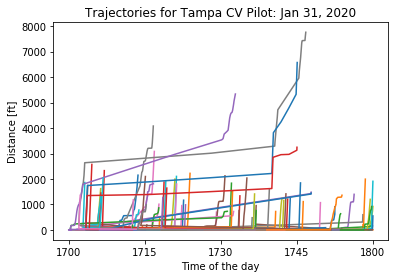

In [0]:
from math import sin, cos, sqrt, atan2, radians
from random import *

def distance(la1, lo1, la2, lo2):
	# approximate radius of earth in km
	R = 6373.0

	lat1 = radians(la1)
	lon1 = radians(lo1)
	lat2 = radians(la2)
	lon2 = radians(lo2)

	dlon = lon2 - lon1
	dlat = lat2 - lat1

	a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
	c = 2 * atan2(sqrt(a), sqrt(1 - a))
	return R * c

n=0
Data=[[['', '', '', '']]]
with open('SmoothenedBSMData_2020-01-31_17-18.csv') as file:
  for line in file:
    n+=1
    if n>1:
      f=line.split('\n')[0].split(',')
      ID, t, lat, lon= int(f[0]), float(f[1]), float(f[2]), float(f[3])
      if Data[-1][0][0]!=ID:
        Data.append([[ID, t, lat, lon]])
      else:
        Data[-1].append([ID, t, lat, lon])

Data=Data[1:]
SpeedData=[['ID', 'Time-stamp', 'Latitude', 'Longitude', 'Distance_ft', 'Speed_mph', 'vector_u', 'vector_v', 'Accl_mph_ps']]
for i in Data:
  dist=[[t], [0.0]]
  t=i[0][1]
  ID=i[0][0]
  for j in range(1, len(i)):
    d=distance(i[j-1][2], i[j-1][3], i[j][2], i[j][3])*3280.84
    dist[0].append(i[j][1])
    dist[1].append(dist[1][-1]+d)
    speed=d/(i[j][1]-i[j-1][1])*0.681818
    if j>1:
      u=distance(i[j-1][2], i[j-1][3], i[j-1][2], i[j][3])
      v=distance(i[j-1][2], i[j-1][3], i[j][2], i[j-1][3])
      l1=(u**2+v**2)**.5
      try:
        SpeedData.append([ID, i[j][1], i[j][2], i[j][3], d, speed, u/l1, v/l1, (speed-speed1)/(i[j][1]-i[j-1][1])])
      except ZeroDivisionError:
        a=1
    speed1=speed
  if random()>0.9:
    plt.plot(dist[0], dist[1], label=str(ID))

plt.title('Trajectories for Tampa CV Pilot: Jan 31, 2020')
plt.xlabel('Time of the day')
plt.ylabel('Distance [ft]')
plt.xticks((0, 900, 1800, 2700, 3600), ('1700', '1715', '1730', '1745', '1800'))
plt.show()
  
with open("Smoothened-BSMData-Speed+Accl_2020-01-31_17-18.csv", "w", newline="") as f:
  writer = csv.writer(f)
  writer.writerows(SpeedData)


Based on this plot, there are long stretches of distance vs time lines almost parallel to the time axis. This could have been a result of **IDs being recycled in the network**.